In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/benjamin/Masterphase/Mastercode


## Version 1: Own MCMC sampling in python

Sampling from the Hamiltonian $H = \frac{1}{2} \sum_{<i,j>}(1-s_i\cdot s_j)$

Therefore partition function is $Z=\sum_{{s_i}}\exp(-\beta H)$

Sample initial distribution randomly. Step: Do a spin flip, accept if lower energy. If higher energy, accept with probability $\exp(-\frac{\Delta E}{T})$

In [4]:
from Ising.Simulator import IsingSimulator

0.5


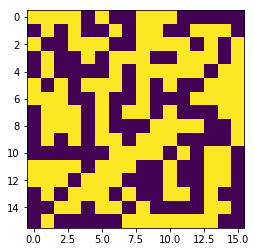

0.615384615385


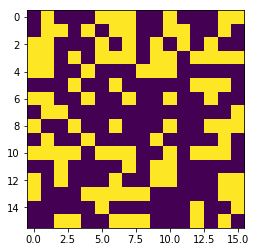

0.730769230769


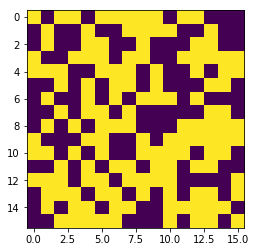

0.846153846154


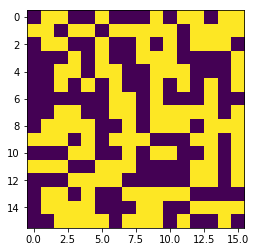

0.961538461538


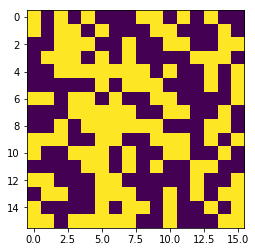

1.07692307692


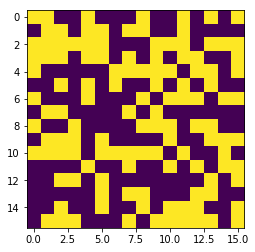

1.19230769231


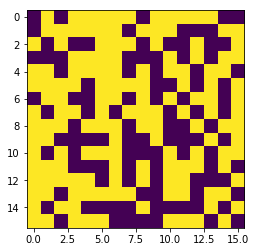

1.30769230769


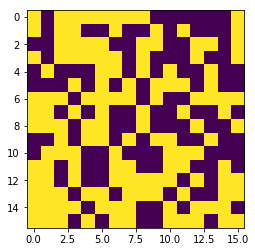

1.42307692308


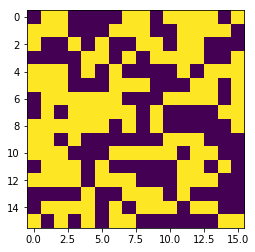

1.53846153846


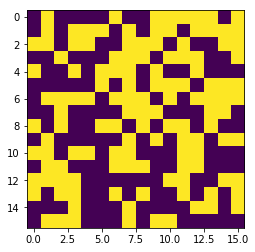

1.65384615385


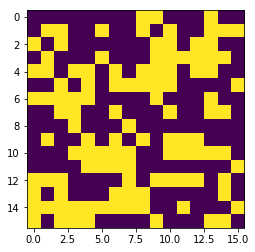

1.76923076923


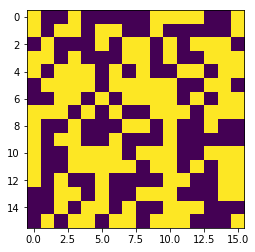

1.88461538462


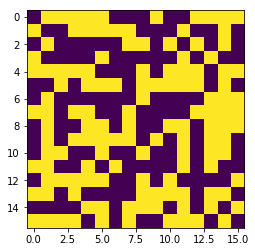

2.0


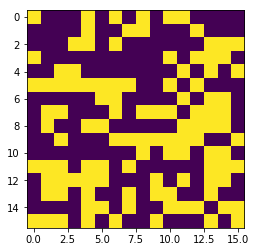

2.11538461538


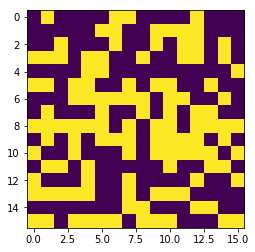

2.23076923077


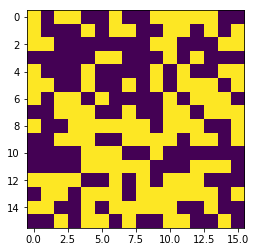

2.34615384615


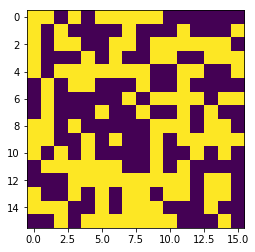

2.46153846154


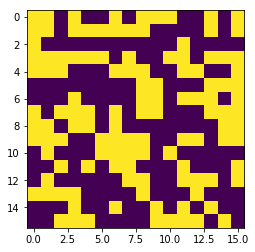

2.57692307692


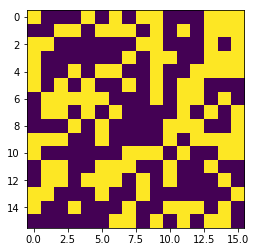

2.69230769231


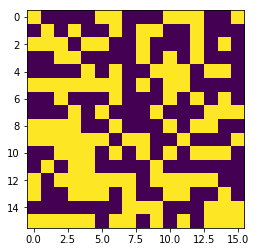

2.80769230769


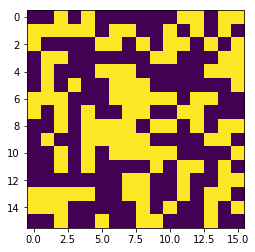

2.92307692308


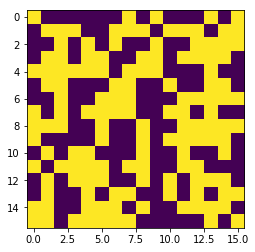

3.03846153846


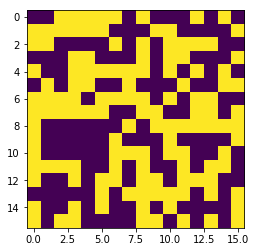

3.15384615385


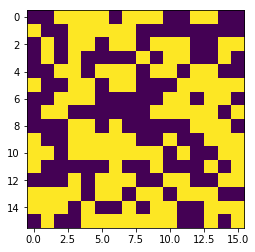

3.26923076923


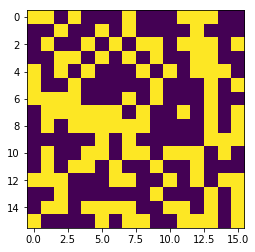

3.38461538462


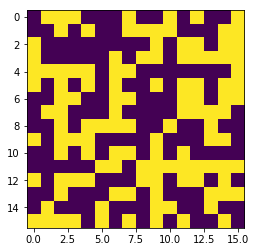

3.5


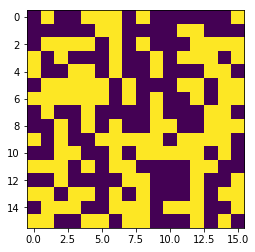

3.61538461538


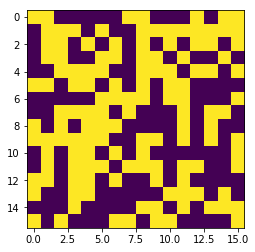

3.73076923077


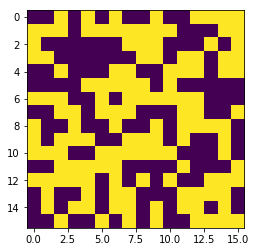

3.84615384615


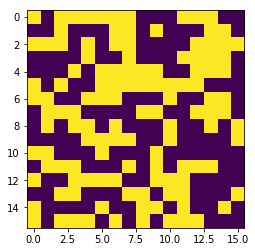

3.96153846154


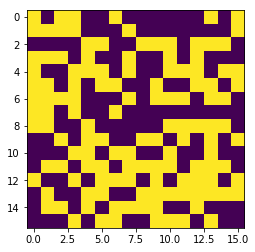

4.07692307692


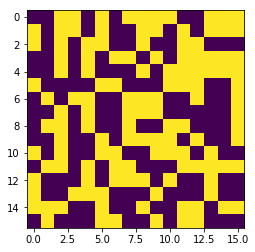

4.19230769231


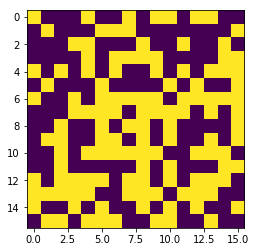

4.30769230769


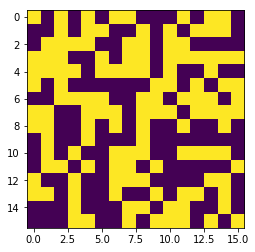

4.42307692308


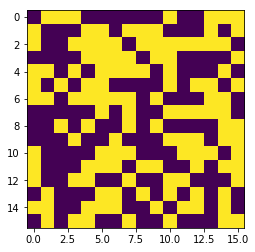

4.53846153846


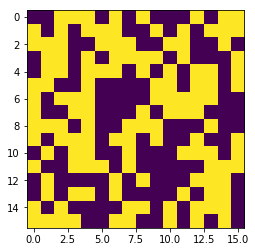

4.65384615385


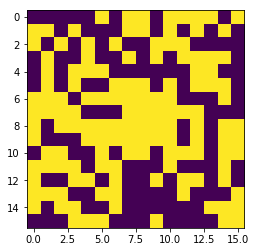

4.76923076923


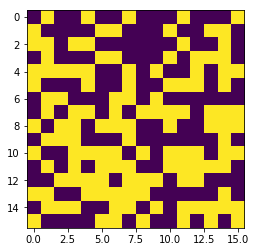

4.88461538462


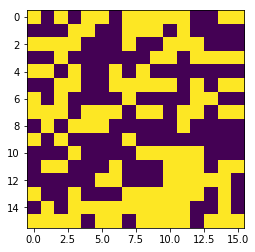

5.0


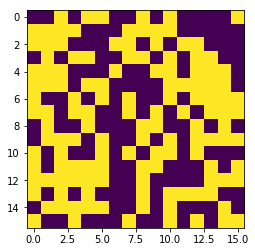

In [5]:
# preview of sampling
energies = []
for T in np.linspace(0.5,5,40):
    print(T)
    s = IsingSimulator(J=-1,L=16, T = T)
    s.step(n=100000)
    plt.imshow(s.lattice, interpolation='none')
    plt.show()

### Burn-in
Prepare array of simulators at different temperatures and run for many steps to thermalize

In [22]:
s = []
for T in np.linspace(0.5,4,20):
    print("At burn-in of Ising MCMC simulator at T={}".format(T))
    s.append(IsingSimulator(J=-1,L=16,T=T))
    # burn-in
    [None for _ in s[-1].step(10000)]

At burn-in of Ising MCMC simulator at T=0.5
At burn-in of Ising MCMC simulator at T=0.6842105263157895
At burn-in of Ising MCMC simulator at T=0.868421052631579
At burn-in of Ising MCMC simulator at T=1.0526315789473684
At burn-in of Ising MCMC simulator at T=1.236842105263158
At burn-in of Ising MCMC simulator at T=1.4210526315789473
At burn-in of Ising MCMC simulator at T=1.6052631578947367
At burn-in of Ising MCMC simulator at T=1.7894736842105263
At burn-in of Ising MCMC simulator at T=1.9736842105263157
At burn-in of Ising MCMC simulator at T=2.1578947368421053
At burn-in of Ising MCMC simulator at T=2.3421052631578947
At burn-in of Ising MCMC simulator at T=2.526315789473684
At burn-in of Ising MCMC simulator at T=2.7105263157894735
At burn-in of Ising MCMC simulator at T=2.894736842105263
At burn-in of Ising MCMC simulator at T=3.0789473684210527
At burn-in of Ising MCMC simulator at T=3.263157894736842
At burn-in of Ising MCMC simulator at T=3.4473684210526314
At burn-in of Isi

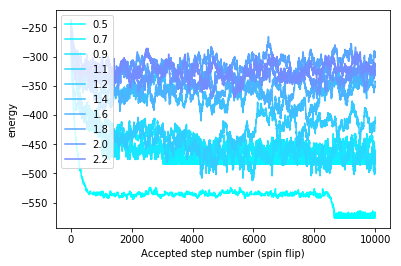

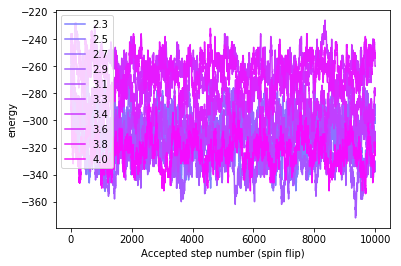

In [23]:
# check thermalization
for i in range(math.floor(len(s)/2)):
    plt.plot(s[i].energies, color = plt.cm.cool(i/len(s)), label="{}".format(round(s[i].T,1)))
plt.legend(loc='upper left')
plt.ylabel("energy")
plt.xlabel("Accepted step number (spin flip)")
plt.show()

for i in range(math.ceil(len(s)/2), len(s)):
    plt.plot(s[i].energies, color = plt.cm.cool(i/len(s)), label="{}".format(round(s[i].T,1)))
plt.legend(loc='upper left')
plt.ylabel("energy")
plt.xlabel("Accepted step number (spin flip)")
plt.show()

### Sampling to generate Training and Test set

In [24]:
def sample_batch(simulators, n_simulator, steps=2):
        
    # make sure all simulators have the same grid size
    assert(len(np.unique([s.L for s in simulators]))==1)
    
    # flatten array
    n_total = n_simulator*len(simulators)
    spin_configs = np.zeros((n_total, simulators[0].L**2))
    labels = np.zeros((n_total, 2))
    temperatures = np.zeros(n_total)
    
    for s, i in zip(simulators, range(len(simulators))):
        rows = range(i*n_simulator,(i+1)*n_simulator)
        spin_configs[rows, :] = np.array([l.flatten() for l in s.sample(n_simulator, steps)])
        
        # create labels: above or below critical temperature
        if abs(s.T/s.J) < 2.2691:
            labels[rows,0] = 1
        else:
            labels[rows,1] = 1
            
        temperatures[rows] = abs(s.T/s.J)
            
    
    # shuffle array
    I = np.arange(n_total)
    np.random.shuffle(I)
    
    return((spin_configs[I,:], labels[I,:], temperatures[I]))

In [25]:
train = sample_batch(s, 500, steps=10)
test = sample_batch(s, 10, steps=100)

## Version 2: Use dataset generated by Lukas' library
Much, much faster since written in C++, more control over thermalization and auto-correlation

In [ ]:
from IsingData import IsingData

In [ ]:
data = IsingData("/home/benjamin/SpinSystems/data/dataset/")

In [ ]:
train = data.train_data
test = data.test_data

In [ ]:
rows = np.random.randint(20000, size=30)

for i in np.sort(rows):
    im = np.reshape(data.train_data[0][i,:], (16,16))
    print(data.train_data[2][i])
    plt.imshow(im, vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

## Look at Data with TSNE

In [26]:
# subsample training set
rows = range(1,10000)
t2 = (train[0][rows], train[1][rows], train[2][rows])

In [27]:
# dimensionality reduction via tsne
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(t2[0])
t2_pca = pca.transform(t2[0])

In [28]:
from sklearn.manifold import TSNE
train_embedded = TSNE(n_components=2).fit_transform(t2_pca)

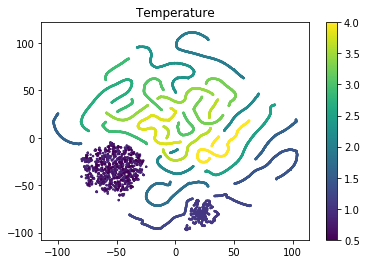

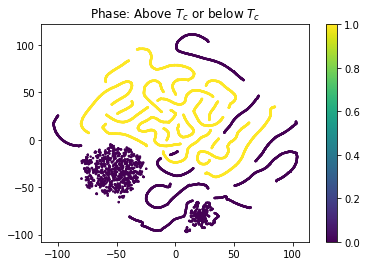

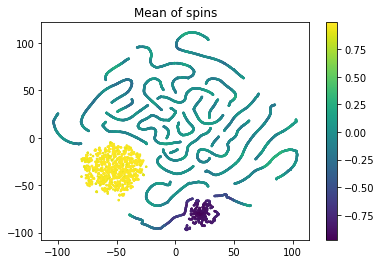

In [29]:
plt.scatter(train_embedded[:,0], train_embedded[:,1], c=t2[2], s=2)
plt.colorbar()
plt.title("Temperature")
plt.show()

plt.scatter(train_embedded[:,0], train_embedded[:,1], c=t2[2]>2.269, s=2)
plt.colorbar()
plt.title("Phase: Above $T_c$ or below $T_c$")
plt.show()

plt.scatter(train_embedded[:,0], train_embedded[:,1], c=np.mean(t2[0], axis=1), s=2)
plt.colorbar()
plt.title("Mean of spins")
plt.show()

## Try to classify with neural networks
### Simple Neural network
Create a very simple neural network with no hidden layers, a relu activation function, cross entropy loss and learning by minibatch gradient descent

In [47]:
from NN.SimpleNN import SimpleNN

In [48]:
nn = SimpleNN(16)

In [49]:
nn.train(train[0], train[1], learning_rate = 0.1, epochs=100, valid_data=test[0], valid_labels=test[1])

Training 100 epochs took 6.487s
Accuracy is 0.7200000286102295


In [50]:
I = test[2]<1.5
I = range(len(test[2]))
t = test[0][I]
l = test[1][I]

In [51]:
nn.evaluate(t, l)

0.71499997

In [52]:
nn.confusion(test[0], test[1])

array([[ 0.73,  0.3 ],
       [ 0.27,  0.7 ]])

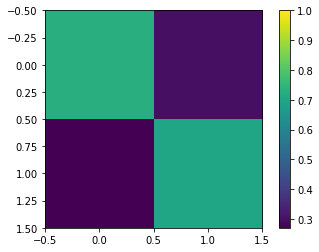

In [53]:
plt.imshow(nn.confusion(test[0], test[1]), vmax=1)
plt.colorbar()

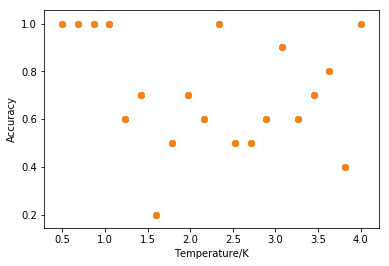

In [54]:
t, acc = nn.evaluate_T_dependence(test)
plt.scatter(t,acc)

### Add hidden layer to neural network
modify previous architecture by adding a fully connected hidden layer and using the Adam Optimizer (adaptive moments) rather than simple gradient descent

In [55]:
from NN.PaperNN import PaperNN
pnn = PaperNN(16)

In [56]:
pnn.train(train[0], train[1], learning_rate = 1e-4, epochs=150, valid_data=test[0], valid_labels=test[1])

Training 150 epochs took 15.035s
Accuracy is 0.7799999713897705


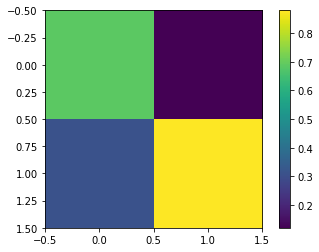

In [57]:
plt.imshow(pnn.confusion(test[0], test[1]))
plt.colorbar()

Text(0,0.5,'Accuracy')

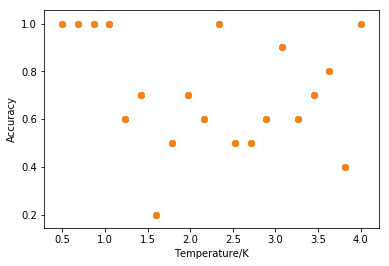

In [58]:
t, acc = nn.evaluate_T_dependence(test)
plt.scatter(t,acc)
plt.xlabel("Temperature/K")
plt.ylabel("Accuracy")

### Use a convolutional neural network
Get fancy: Convolutional layer with 32 filters on 3x3 window, followed by 2x2 maxpool, followed by fully connected layer, followed by readout layer

In [59]:
from NN.ConvNN import ConvNN
cnn = ConvNN(16)

In [60]:
cnn.train(train[0], train[1], learning_rate = 1e-4, epochs=80, valid_data=test[0], valid_labels=test[1])

Training 80 epochs took 24.108s
Accuracy is 0.8999999761581421


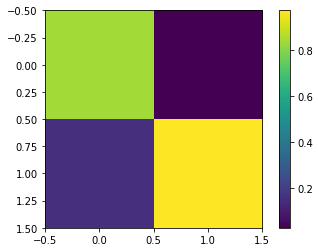

In [62]:
plt.imshow(cnn.confusion(test[0],test[1]))
plt.colorbar()

Text(0.5,0,'Temperature/K')

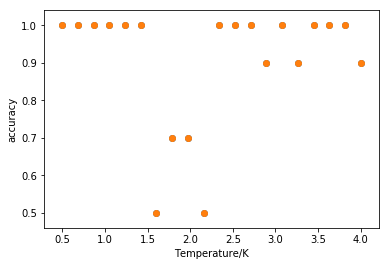

In [63]:
temperatures, accuracies = cnn.evaluate_T_dependence(test)    
plt.scatter(temperatures, accuracies)
plt.ylabel("accuracy")
plt.xlabel("Temperature/K")